In [ ]:
"""
Author: Eunmi Joo

Patient-wise Stroke Type Classifier Model Implementation - Transformer Architecture
"""

In [2]:
import torch
import os
device = "cuda:6" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(device)
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler
import optuna
from optuna.trial import TrialState
import logging
import sys
import seaborn as sns
import pickle
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
import torchvision.models as models
import torch.nn.functional as F
# from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import pydicom
import warnings
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings("ignore")

In [4]:
with open("/ceph/inestp02/stroke_classifier/data/patientwise/preprocess/features_resnet152.pickle", "rb") as f:
    features = pickle.load(f)
with open('/ceph/inestp02/stroke_classifier/data/patientwise/preprocess/patient_data_combine_wo_dicom.pickle', 'rb') as f:
    patientwise_scans = pickle.load(f)

In [5]:
def extract_imglen(data):
    img_len =[]
    for key in data:
        img_len.append(len(data[key]['img_preprocess']))
    return img_len
img_len = extract_imglen(patientwise_scans)

In [6]:
class PatientwiseDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 80):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class CNNTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(CNNTransformer, self).__init__()
        
        # fine_cnn = cnn_model
        # modules = list(fine_cnn.children())[:-1]
        # self.cnn = nn.Sequential(*modules)
        
        # self.embedding = nn.Linear(in_features, d_model)
        
        self.encoder_layer = nn.TransformerEncoderLayer(input_dim, nhead, dim_feedforward, dropout, activation)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        x = self.encoder(x)
        # print(x.shape)
        x.shape
        
        x = x.mean(dim=0)  # Average pooling across the sequence length dimension
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x
    
# Set the hyperparameters


model = models.resnet152(weights="DEFAULT")
# in_features = model.fc.in_features

In [7]:
state_dict_path = f'models_state_dict/runs/'
if not os.path.exists(state_dict_path):
        os.makedirs(state_dict_path)

#model save path
model_path = f'models/runs/'
if not os.path.exists(model_path):
        os.makedirs(model_path)

#tensorboard path
tensorboard_path = f'tensorboard/runs/'
if not os.path.exists(tensorboard_path):
        os.makedirs(tensorboard_path)


#writing log for tensorboard
writer = SummaryWriter(log_dir = f'{tensorboard_path}/resnet152')

In [8]:
X = features
y = torch.Tensor(list(i['patient_label'] for i in patientwise_scans.values()))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
train_dataset = PatientwiseDataset(X_train, y_train)
test_dataset = PatientwiseDataset(X_test, y_test)
val_dataset = PatientwiseDataset(X_val, y_val)

In [9]:
# Create DataLoader for batched training
num_epochs = 500
random_state = 42
maxlen = 80
input_dim = 2048
output_dim = 3
d_model = 2048
dropout = 0.05
batch_size = 8

best_model = None
best_config = None
best_val_loss = np.inf

In [25]:
import itertools
lst_dim_feedforward = [128, 256, 512, 1024, 2048]
lst_nhead = [2, 4, 8]
lst_learning_rate = [1e-4, 1e-3, 1e-2, 1e-1]
lst_weight_decay = [1e-9, 1e-8, 1e-7, 1e-6]

config_list = [lst_dim_feedforward, lst_nhead, lst_learning_rate, lst_weight_decay]
configs = list(itertools.product(*config_list))

In [26]:
loss_lst = []
for idx, config in enumerate(configs):
    best_model = None
    best_config = None
    best_val_loss = np.inf
    writer = SummaryWriter(log_dir = f'{tensorboard_path}/transformer_{idx}')
    dim_feedforward, nhead, learning_rate, weight_decay = config
    #dataloader
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

    # Create an instance of the GRU classifier model
    model = CNNTransformer(input_dim, output_dim, d_model, nhead, dim_feedforward, dropout, activation="relu").to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    patience = 20
    patience_check = 0
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        #train
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for batch_inputs, batch_targets in train_loader:
            # Move data to the device
            batch_inputs = batch_inputs.squeeze().to(device)
            one_hot_targets = F.one_hot(batch_targets.long(), num_classes=3)
            one_hot_targets = one_hot_targets.to(device)
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_inputs)
            # Compute the loss
            loss = criterion(outputs, one_hot_targets.float())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss and count correct predictions
            train_loss += loss.item()
            predicted = torch.argmax(outputs, 1)
            train_acc += (predicted == batch_targets.to(device)).sum().item()

        # Print the average loss and accuracy for the epoch
        # Print loss and accuracy for epoch
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Acc/train", train_acc, epoch)   
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}'.format(epoch+1, num_epochs, train_loss, train_acc))

        # validation
        
        model.eval()

        # Initialize variables to track loss and accuracy
        val_loss = 0.0
        val_acc = 0.0

        # Disable gradient computation
        with torch.no_grad():
            # Iterate over validation data
            for batch_inputs, batch_targets in val_loader:
                batch_inputs = batch_inputs.squeeze().to(device)
                one_hot_targets = F.one_hot(batch_targets.long(), num_classes=3)
                one_hot_targets = one_hot_targets.to(device)
                # Zero the gradients

                # Forward pass
                outputs = model(batch_inputs)
                # Compute the loss
                loss = criterion(outputs, one_hot_targets.float())
                val_loss += loss.item()
                predicted = torch.argmax(outputs, 1)
                val_acc += (predicted == batch_targets.to(device)).sum().item()
                # Backward pass and optimization
            
            # Compute average loss and accuracy for epoch
            val_loss /= len(val_loader.dataset)
            val_acc /= len(val_loader.dataset)
            writer.add_scalar("Loss/validation", val_loss, epoch)
            writer.add_scalar("Acc/validation", val_acc, epoch)
            print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch+1, num_epochs, val_loss, val_acc))
            
            # early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                patience_check = 0
            else:
                patience_check += 1 

            if patience_check >= patience:
                break
    # Save the trained model
    # torch.save(model.state_dict(), f"./transformer/transformer_classifier.pth")
    loss_lst.append(val_loss)
    torch.save({
                'input_dim': input_dim,
                'output_dim': output_dim,
                'd_model': d_model,
                'nhead': nhead,
                'dim_feedforward': dim_feedforward,
                'dropout': dropout,
                'model_state_dict': best_model.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                }, "/ceph/inestp02/stroke_classifier/src/transformer/transformer_classifier_{idx}.pth")
    torch.cuda.empty_cache()
with open("/ceph/inestp02/stroke_classifier/src/transformer/loss_lst.pickle", "wb") as f:
    pickle.dump(loss_lst, f)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 0.0830, Train Accuracy: 0.6897
Epoch [1/500], Validation Loss: 0.0516, Validation Accuracy: 0.8214
Epoch [2/500], Train Loss: 0.0462, Train Accuracy: 0.8336
Epoch [2/500], Validation Loss: 0.0354, Validation Accuracy: 0.8690
Epoch [3/500], Train Loss: 0.0366, Train Accuracy: 0.8668
Epoch [3/500], Validation Loss: 0.0461, Validation Accuracy: 0.8095
Epoch [4/500], Train Loss: 0.0292, Train Accuracy: 0.9001
Epoch [4/500], Validation Loss: 0.0555, Validation Accuracy: 0.8214
Epoch [5/500], Train Loss: 0.0200, Train Accuracy: 0.9361
Epoch [5/500], Validation Loss: 0.0431, Validation Accuracy: 0.8452
Epoch [6/500], Train Loss: 0.0140, Train Accuracy: 0.9561
Epoch [6/500], Validation Loss: 0.0598, Validation Accuracy: 0.8571
Epoch [7/500], Train Loss: 0.0094, Train Accuracy: 0.9654
Epoch [7/500], Validation Loss: 0.0751, Validation Accuracy: 0.8095
Epoch [8/500], Train Loss: 0.0057, Train Accuracy: 0.9893
Epoch [8/500], Validation Loss: 0.1082, Validation Accuracy:

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 0.0848, Train Accuracy: 0.6991
Epoch [1/500], Validation Loss: 0.0497, Validation Accuracy: 0.8333
Epoch [2/500], Train Loss: 0.0427, Train Accuracy: 0.8429
Epoch [2/500], Validation Loss: 0.0407, Validation Accuracy: 0.8571
Epoch [3/500], Train Loss: 0.0366, Train Accuracy: 0.8735
Epoch [3/500], Validation Loss: 0.0503, Validation Accuracy: 0.8571
Epoch [4/500], Train Loss: 0.0262, Train Accuracy: 0.9161
Epoch [4/500], Validation Loss: 0.0365, Validation Accuracy: 0.8571
Epoch [5/500], Train Loss: 0.0264, Train Accuracy: 0.9095
Epoch [5/500], Validation Loss: 0.0489, Validation Accuracy: 0.8571
Epoch [6/500], Train Loss: 0.0102, Train Accuracy: 0.9694
Epoch [6/500], Validation Loss: 0.0711, Validation Accuracy: 0.8690
Epoch [7/500], Train Loss: 0.0072, Train Accuracy: 0.9774
Epoch [7/500], Validation Loss: 0.0827, Validation Accuracy: 0.8333
Epoch [8/500], Train Loss: 0.0024, Train Accuracy: 0.9947
Epoch [8/500], Validation Loss: 0.0757, Validation Accuracy:

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 0.0803, Train Accuracy: 0.6631
Epoch [1/500], Validation Loss: 0.0699, Validation Accuracy: 0.7024
Epoch [2/500], Train Loss: 0.0469, Train Accuracy: 0.8242
Epoch [2/500], Validation Loss: 0.0634, Validation Accuracy: 0.7976
Epoch [3/500], Train Loss: 0.0407, Train Accuracy: 0.8642
Epoch [3/500], Validation Loss: 0.0708, Validation Accuracy: 0.7619
Epoch [4/500], Train Loss: 0.0292, Train Accuracy: 0.9148
Epoch [4/500], Validation Loss: 0.0508, Validation Accuracy: 0.8214
Epoch [5/500], Train Loss: 0.0179, Train Accuracy: 0.9481
Epoch [5/500], Validation Loss: 0.0452, Validation Accuracy: 0.8690
Epoch [6/500], Train Loss: 0.0134, Train Accuracy: 0.9561
Epoch [6/500], Validation Loss: 0.0588, Validation Accuracy: 0.8095
Epoch [7/500], Train Loss: 0.0110, Train Accuracy: 0.9640
Epoch [7/500], Validation Loss: 0.0526, Validation Accuracy: 0.8571
Epoch [8/500], Train Loss: 0.0048, Train Accuracy: 0.9867


KeyboardInterrupt: 

In [32]:
from sklearn.metrics import f1_score

def test_accuracy(model):
    #test
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle = False)

    # Initialize variables to track loss and accuracy
    # test_loss = 0.0
    test_acc = 0.0
    predicted_labels = []
    true_labels = []

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over validation data
        for batch_inputs, batch_targets in test_loader:
            batch_inputs = batch_inputs.squeeze().to(device)
            one_hot_targets = F.one_hot(batch_targets.long(), num_classes=3)
            one_hot_targets = one_hot_targets.to(device)
            
            outputs = model(batch_inputs)
            # Compute the loss
            # loss = criterion(outputs, one_hot_targets.float())

            # # Update loss and accuracy
            # test_loss += loss.item()
            predicted = torch.argmax(outputs, 1)
            test_acc += (predicted == batch_targets.to(device)).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(batch_targets.cpu().numpy())

    test_acc /= len(test_loader.dataset)
    
    # print("Classification report")
    # print(classification_report(true_labels, predicted_labels))

    # Calculate and print confusion matrix
    # print("Confusion Matrix:")
    print("f1 score:", f1_score(true_labels, predicted_labels, average=None))
    cf_matrix = confusion_matrix(true_labels, predicted_labels)
    print(cf_matrix)
    sns.heatmap(cf_matrix, annot=True)
    
    # Compute average loss and accuracy for epoch
    # test_loss /= len(test_loader.dataset)

    # writer.add_scalar("Loss/test", test_loss)
    # writer.add_scalar("Acc/test", test_acc)     
    # Print loss and accuracy for epoch
    return test_acc

In [11]:
with open("/ceph/inestp02/stroke_classifier/src/transformer/loss_lst.pickle", 'rb') as f:
    loss_lst = pickle.load(f)

In [23]:
loss_np = np.array(loss_lst)
sorted_idx = np.argsort(loss_np)[:10]
sorted_idx

array([230, 215, 122, 203,  57,  11,  81, 214,  33,  69])

In [27]:
for idx in sorted_idx:
    checkpoint = torch.load(f"./transformer/transformer_classifier_{idx}.pth")

    input_dim = checkpoint['input_dim']
    output_dim = checkpoint['output_dim']
    d_model = checkpoint['d_model']
    nhead = checkpoint['nhead']
    dim_feedforward = checkpoint['dim_feedforward']
    dropout = checkpoint['dropout']

    model = CNNTransformer(input_dim, output_dim, d_model, nhead, dim_feedforward, dropout, activation="relu").to(device)

    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"test acc of {idx}th model:", test_accuracy(model))

test acc of 230th model: 0.7353760445682451
test acc of 215th model: 0.7910863509749304
test acc of 122th model: 0.7576601671309192
test acc of 203th model: 0.7325905292479109
test acc of 57th model: 0.7075208913649025
test acc of 11th model: 0.6239554317548747
test acc of 81th model: 0.83008356545961
test acc of 214th model: 0.7883008356545961
test acc of 33th model: 0.8328690807799443
test acc of 69th model: 0.8022284122562674


f1 score: [0.75313808 0.75303644 0.99137931]
[[ 90  27   0]
 [ 32  93   2]
 [  0   0 115]]
test acc of 69th model: 0.83008356545961


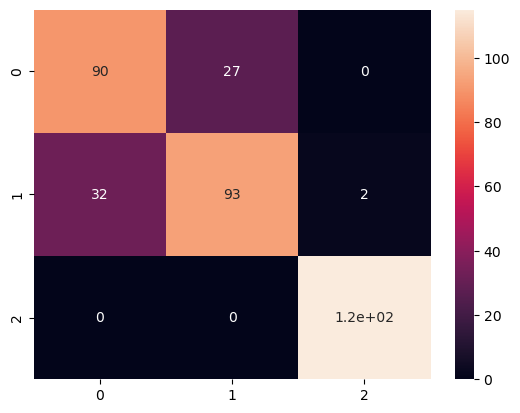

In [33]:

checkpoint = torch.load(f"./transformer/transformer_classifier_81.pth")

input_dim = checkpoint['input_dim']
output_dim = checkpoint['output_dim']
d_model = checkpoint['d_model']
nhead = checkpoint['nhead']
dim_feedforward = checkpoint['dim_feedforward']
dropout = checkpoint['dropout']

model = CNNTransformer(input_dim, output_dim, d_model, nhead, dim_feedforward, dropout, activation="relu").to(device)

model.load_state_dict(checkpoint['model_state_dict'])

print(f"test acc of {idx}th model:", test_accuracy(model))